In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import cv2
import mimetypes
import argparse
import imutils
import zipfile
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Unzip the dataset and save to Google Drive
with zipfile.ZipFile('/content/drive/MyDrive/Clover_Multi_detection.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Clover_multi_new')

# Define dataset path
dataset_path = '/content/drive/MyDrive/Clover_multi_new'

In [ ]:
class_names = ['Clover']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(6, 6))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

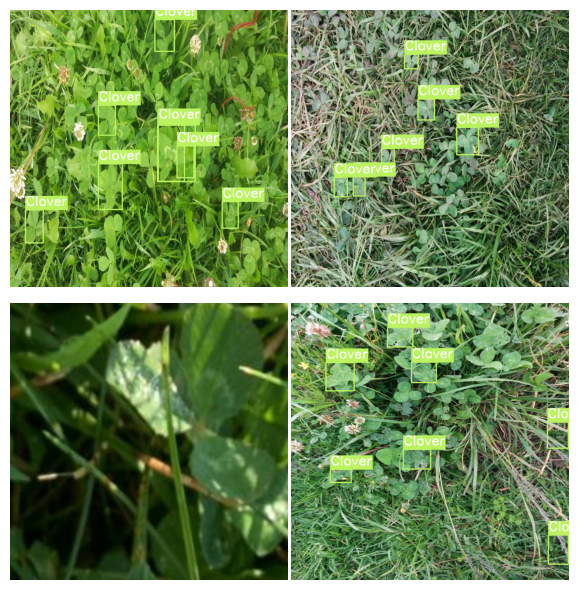

In [ ]:
# Visualize a few training images.
plot(
    image_paths='/content/drive/MyDrive/Clover_multi_new/train/images/*',
    label_paths='/content/drive/MyDrive/Clover_multi_new/train/labels/*',
    num_samples=4,
)

In [ ]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.8/871.8 kB 59.2 MB/s eta 0:00:00


In [ ]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 50

In [ ]:
!yolo task=detect mode=train \
    model=yolov8s.pt \
    imgsz=640 \
    data=/content/drive/MyDrive/Clover_multi_new/data.yaml \
    epochs={EPOCHS} \
    batch=16 \
    name=yolov8s_v8_50e \
    mosaic=1.0 \
    mixup=0.5 \
    copy_paste=0.3 \
    iou=0.5 \
    conf=0.001 \
    max_det=300 \
    patience=25 \
    save_period=10 \
    nms=True

100% 21.5M/21.5M [00:00<00:00, 108MB/s] 
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/drive/MyDrive/Clover_multi_new/data.yaml, epochs=50, time=None, patience=25, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=yolov8s_v8_50e, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=0.001, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, 

In [ ]:
!cp -r /content/runs/detect/yolov8s_eval2 /content/drive/MyDrive/Clover_multi_new/yolov8s_model/evaluation2/


In [ ]:
#Evaluation result on valid dataset
!yolo task=detect mode=val model=/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt name=yolov8s_eval data=/content/drive/MyDrive/Clover_multi_new/data.yaml


Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/drive/MyDrive/Clover_multi_new/valid/labels.cache... 283 images, 76 backgrounds, 3 corrupt: 100% 359/359 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/drive/MyDrive/Clover_multi_new/valid/images/1_000668_jpg.rf.780394de455233a8ba8098c4c7745f1a.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/Clover_multi_new/valid/images/poly_img16_png_jpg.rf.a7a64ba50e0a7de8f55549dae5bfefb4.jpg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/Clover_multi_new/valid/images/poly_img2_png_jpg.rf.9be650ab65af534ac405c852ddcd5409.jpg: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /content/drive/MyDrive/Clover_multi_new/valid/images

In [ ]:
#Evaluation result on test dataset
!yolo task=detect mode=val model=/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt name=yolov8s_eval data=/content/drive/MyDrive/Clover_multi_new/data1.yaml


Ultralytics YOLOv8.2.90 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
100% 755k/755k [00:00<00:00, 113MB/s]
val: Scanning /content/drive/MyDrive/Clover_multi_new/test/labels.cache... 144 images, 0 backgrounds, 0 corrupt: 100% 144/144 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:15<00:00,  1.73s/it]
                   all        144       1167      0.478      0.436       0.45      0.311
Speed: 4.5ms preprocess, 12.5ms inference, 0.1ms loss, 17.4ms postprocess per image
Results saved to runs/detect/yolov8s_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!cp -r /content/runs/detect/yolov8s_eval /content/drive/MyDrive/Clover_multi_new/evaluation_test/


In [ ]:
#Prediction  result on test dataset
!yolo task=detect \
mode=predict \
model=/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt \
source=/content/drive/MyDrive/Clover_multi_new/test/images \
imgsz=640 \
name=yolov8s_eval \
data=/content/drive/MyDrive/Clover_multi_new/data.yaml \
show_labels=True \
save_txt=True\
save_conf=True

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg: 640x640 9 Clovers, 16.3ms
image 2/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg: 640x640 8 Clovers, 17.5ms
image 3/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg: 640x640 2 Clovers, 16.3ms
image 4/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000022_jpg.rf.0cc3fbad77af627e9888df4997063f21.jpg: 640x640 2 Clovers, 16.3ms
image 5/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000032_jpg.rf.6fe9aa3f450bf428a5bc877d1508a892.jpg: 640x640 20 Clovers, 16.2ms
image 6/144 /content/drive/MyDrive/Clover_multi_new/test/images/1_000034_jpg.rf.9a5f277f22edb6058dc05e9093dd

In [ ]:
!cp -r /content/runs/detect/yolov8s_eval4 /content/drive/MyDrive/Clover_multi_new/yolov8s_model/prediction2/


In [ ]:
#Prediction result on new test dataset contains false images, non clovers etc
!yolo task=detect \
mode=predict \
model=/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt \
source=/content/drive/MyDrive/test_2108 \
imgsz=640 \
name=yolov8s_eval \
data=/content/drive/MyDrive/Clover_multi_new/data.yaml \
show_labels=True \
save_txt=True\
save_conf=True

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs

image 1/80 /content/drive/MyDrive/test_2108/1005_jpg.rf.c38450024a465c7a7ef2e23f37e70c4c.jpg: 640x640 (no detections), 16.4ms
image 2/80 /content/drive/MyDrive/test_2108/11126_jpg.rf.100d16a1fd7d2482d947b9a7fad365a5.jpg: 640x640 2 Clovers, 16.4ms
image 3/80 /content/drive/MyDrive/test_2108/11595_jpg.rf.fc98910c5a14d5ad61a071fbe4569ea2.jpg_crop_4.jpg: 640x640 (no detections), 16.4ms
image 4/80 /content/drive/MyDrive/test_2108/11886_jpg.rf.999e8e81dcdf93d3c92419f4f9bbbdd6.jpg: 640x640 7 Clovers, 16.4ms
image 5/80 /content/drive/MyDrive/test_2108/12256_jpg.rf.1b308bd6918cce53038a45e6d20a0284.jpg: 640x640 4 Clovers, 16.5ms
image 6/80 /content/drive/MyDrive/test_2108/12278_jpg.rf.8e9a0cde3a9c96356d2cc16efdb71d84.jpg_crop_0.jpg: 640x640 (no detections), 16.4ms
image 7/80 /content/drive/MyDrive/test_2108/12278_jpg.rf.8e9a0cd

In [ ]:
import os
import pandas as pd

# Define the path to the directory containing the prediction results
result_dir = '/content/runs/detect/yolov8s_eval3'
labels_dir = os.path.join(result_dir, 'labels')

# Initialize a list to store the bounding box information
bbox_data = []

# Iterate through the text files in the labels directory
for label_file in os.listdir(labels_dir):
    if label_file.endswith('.txt'):
        label_path = os.path.join(labels_dir, label_file)
        image_name = label_file.replace('.txt', '.jpg')

        # Read the content of the label file
        with open(label_path, 'r') as file:
            lines = file.readlines()

        # Extract bounding box coordinates and labels
        for line in lines:
            parts = line.strip().split()
            label = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])
            confidence = float(parts[5]) if len(parts) > 5 else 0.0

            # Calculate xmin, ymin, xmax, ymax
            xmin = int((x_center - width/2) * 640)  # Assuming image width is 640
            ymin = int((y_center - height/2) * 640)  # Assuming image height is 640
            xmax = int((x_center + width/2) * 640)
            ymax = int((y_center + height/2) * 640)

            # Append the data to the list
            bbox_data.append([image_name, xmin, ymin, xmax, ymax, confidence])

# Create a DataFrame from the list
bbox_df = pd.DataFrame(bbox_data, columns=['filename', 'xmin', 'ymin', 'xmax', 'ymax','confidence'])

# Save the DataFrame to a CSV file
csv_path = os.path.join(result_dir, 'pboxes_multi_1.csv')
bbox_df.to_csv(csv_path, index=False)

print(f"Predicted bounding boxes saved to {csv_path}")

Predicted bounding boxes saved to /content/runs/detect/yolov8s_eval3/pboxes_multi_1.csv


In [ ]:
!cp -r /content/runs/detect/yolov8s_eval4/pboxes_multi_2.csv /content/drive/MyDrive/Clover_multi_new/yolov8s_model/prediction2/


In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(6, 6))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

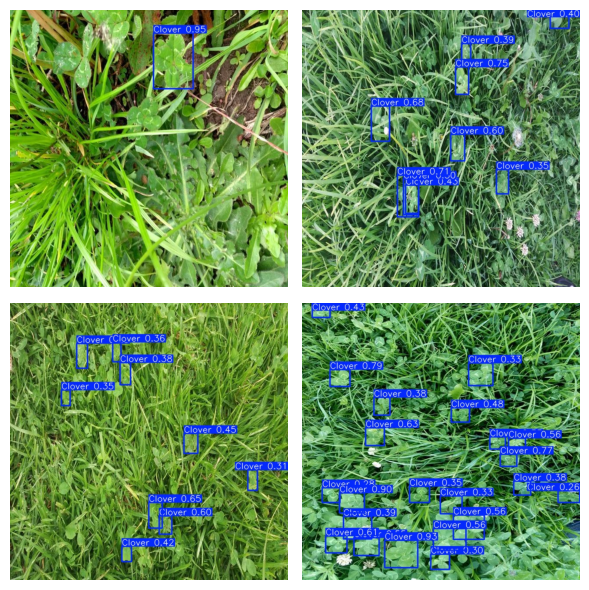

In [ ]:
visualize('runs/detect/yolov8s_eval')

In [ ]:
### implement sahi

In [ ]:
pip install -U sahi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 16.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117030 sha256=b5ca4c47460d895fb4e2cda9ba372f66fb5eee332817f5192aa842b8ef46358b
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


In [ ]:
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sahi.utils.yolov8 import download_yolov8s_model
from ultralytics import YOLO

In [ ]:
# Initialize your YOLOv8 model
model_path = "/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cuda:0"  # or "cpu" if you're not using GPU
)

# Perform sliced prediction
result = get_sliced_prediction(
    "/content/drive/MyDrive/Clover_multi_new/test/images/1_000032_jpg.rf.6fe9aa3f450bf428a5bc877d1508a892.jpg",
    detection_model,
    slice_height=512,
    slice_width=512,
    overlap_height_ratio=0.2,
    overlap_width_ratio=0.2
)

Performing prediction on 4 slices.


In [ ]:
# Export the result
result.export_visuals(export_dir="path/to/export/folder")
print(f"Detections: {result.object_prediction_list}")

Detections: [ObjectPrediction<
    bbox: BoundingBox: <(171.68251037597656, 533.8607482910156, 218.61161041259766, 598.3419189453125), w: 46.929100036621094, h: 64.48117065429688>,
    mask: None,
    score: PredictionScore: <value: 0.8621711730957031>,
    category: Category: <id: 0, name: Clover>>, ObjectPrediction<
    bbox: BoundingBox: <(476.26837158203125, 209.04961395263672, 506.02520751953125, 258.24693298339844), w: 29.7568359375, h: 49.19731903076172>,
    mask: None,
    score: PredictionScore: <value: 0.6961209177970886>,
    category: Category: <id: 0, name: Clover>>, ObjectPrediction<
    bbox: BoundingBox: <(499.0315856933594, 402.38232421875, 529.6537170410156, 453.88018798828125), w: 30.62213134765625, h: 51.49786376953125>,
    mask: None,
    score: PredictionScore: <value: 0.6761654615402222>,
    category: Category: <id: 0, name: Clover>>, ObjectPrediction<
    bbox: BoundingBox: <(373.2128601074219, 46.46809768676758, 407.0485534667969, 110.21363830566406), w: 33.

In [ ]:
# Initialize your YOLOv8 model
model_path = "/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cuda:0"  # or "cpu" if you're not using GPU
)
# Directory containing input images
input_dir = "/content/drive/MyDrive/Clover_multi_new/test/images"
# Directory to save results
output_dir = "/content/drive/MyDrive/Clover_multi_new/results_sahi_1"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process all images in the input directory
for image_path in glob.glob(os.path.join(input_dir, "*.jpg")):
    # Perform sliced prediction with adjusted parameters
    result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=256,  # Reduced slice size to catch smaller objects
        slice_width=256,
        overlap_height_ratio=0.4,  # Increased overlap
        overlap_width_ratio=0.4,
        perform_standard_pred=True,  # Perform both standard and sliced prediction
        postprocess_match_threshold=0.5,  # Adjust based on your needs
        postprocess_class_agnostic=False,  # Set to True if classes are similar
        verbose=1
    )

    # Export the result
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    result.export_visuals(export_dir=output_dir, file_name=os.path.basename(image_path))
    print(f"Processed {image_path}. Output saved to {output_path}")

# Visualize the results
visualize(output_dir)

# Print detection results
for image_path in glob.glob(os.path.join(output_dir, "*.jpg")):
    result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=256,
        slice_width=256,
        overlap_height_ratio=0.4,
        overlap_width_ratio=0.4,
        perform_standard_pred=True,
        postprocess_match_threshold=0.5,
        postprocess_class_agnostic=False,
        verbose=0
    )
    print(f"Detections for {os.path.basename(image_path)}:")
    for obj in result.object_prediction_list:
        print(f"  Class: {obj.category.name}, Confidence: {obj.score.value:.2f}, Bbox: {obj.bbox.to_xywh()}")

Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_1/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_1/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_1/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000022_jpg.rf.0cc3fbad77af627e9888df4997063f21.jpg. Output saved to /con

<Figure size 600x600 with 0 Axes>

In [ ]:
# Initiate  model
model_path = "/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cuda:0"
)
# Directory containing input images
input_dir = "/content/drive/MyDrive/Clover_multi_new/test/images"
# Directory to save results
output_dir = "/content/drive/MyDrive/Clover_multi_new/results_sahi_2"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process all images in the input directory
for image_path in glob.glob(os.path.join(input_dir, "*.jpg")):
    # Perform sliced prediction with adjusted parameters
    result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=128,
        slice_width=128,
        overlap_height_ratio=0.6,
        overlap_width_ratio=0.6,
        perform_standard_pred=True,
        postprocess_match_threshold=0.3,
        postprocess_class_agnostic=True,
        verbose=1
    )

    # Export the result
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    result.export_visuals(export_dir=output_dir, file_name=os.path.basename(image_path))
    print(f"Processed {image_path}. Output saved to {output_path}")

# Visualize the results
visualize(output_dir)

# Print detection results
for image_path in glob.glob(os.path.join(output_dir, "*.jpg")):
    result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=128,
        slice_width=128,
        overlap_height_ratio=0.6,
        overlap_width_ratio=0.6,
        perform_standard_pred=True,
        postprocess_match_threshold=0.3,
        postprocess_class_agnostic=True,
        verbose=0
    )
    print(f"Detections for {os.path.basename(image_path)}:")
    for obj in result.object_prediction_list:
        print(f"  Class: {obj.category.name}, Confidence: {obj.score.value:.2f}, Bbox: {obj.bbox.to_xywh()}")

Performing prediction on 121 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_2/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg
Performing prediction on 121 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_2/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg
Performing prediction on 121 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_2/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg
Performing prediction on 121 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000022_jpg.rf.0cc3fbad77af627e9888df4997063f21.jpg. Output saved to 

<Figure size 600x600 with 0 Axes>

In [ ]:
import os
import glob
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
import csv

# Initialize your YOLOv8 model
model_path = "/content/drive/MyDrive/Clover_multi_new/yolov8s_model/weights/best.pt"
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=model_path,
    confidence_threshold=0.3,
    device="cuda:0"
)

# Directory containing input images
input_dir = "/content/drive/MyDrive/Clover_multi_new/test/images"
# Directory to save results
output_dir = "/content/drive/MyDrive/Clover_multi_new/results_sahi_4"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Create a CSV file to store the results
csv_path = os.path.join(output_dir, "detection_results.csv")
with open(csv_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["File Name", "xmin", "ymin", "xmax", "ymax", "Confidence"])

    # Process all images in the input directory
    for image_path in glob.glob(os.path.join(input_dir, "*.jpg")):
        # Perform sliced prediction optimized for individual clover detection
        result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=256,  # Reduced slice size to catch smaller objects
        slice_width=256,
        overlap_height_ratio=0.4,  # Increased overlap
        overlap_width_ratio=0.4,
        perform_standard_pred=True,  # Perform both standard and sliced prediction
        postprocess_match_threshold=0.5,  # Adjust based on your needs
        postprocess_class_agnostic=False,  # Set to True if classes are similar
        verbose=1
    )

        # Export the result
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        result.export_visuals(export_dir=output_dir, file_name=os.path.basename(image_path))
        print(f"Processed {image_path}. Output saved to {output_path}")

        # Write detection results to CSV
        for obj in result.object_prediction_list:
            bbox = obj.bbox.to_xyxy()
            csv_writer.writerow([
                os.path.basename(image_path),
                bbox[0],  # xmin
                bbox[1],  # ymin
                bbox[2],  # xmax
                bbox[3],  # ymax
                obj.score.value
            ])

# Visualize the results
visualize(output_dir)

# Print detection results
for image_path in glob.glob(os.path.join(output_dir, "*.jpg")):
    result = get_sliced_prediction(
        image_path,
        detection_model,
        slice_height=256,
        slice_width=256,
        overlap_height_ratio=0.4,
        overlap_width_ratio=0.4,
        perform_standard_pred=True,
        postprocess_match_threshold=0.5,
        postprocess_class_agnostic=False,
        verbose=0
    )
    print(f"Detections for {os.path.basename(image_path)}:")
    for obj in result.object_prediction_list:
        bbox = obj.bbox.to_xyxy()
        print(f"Class: Clover, Confidence: {obj.score.value:.2f}, Bbox: {bbox}")

print(f"CSV file with detection results saved to: {csv_path}")

Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_4/1_000012_jpg.rf.aac571464759b6acae1baf3b8b44b2ed.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_4/1_000013_jpg.rf.10e6e11fc181db97e536ab8e2128c43c.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg. Output saved to /content/drive/MyDrive/Clover_multi_new/results_sahi_4/1_000021_jpg.rf.ed1ec8b58d054a87fede8622c4a1381b.jpg
Performing prediction on 16 slices.
Processed /content/drive/MyDrive/Clover_multi_new/test/images/1_000022_jpg.rf.0cc3fbad77af627e9888df4997063f21.jpg. Output saved to /con

<Figure size 600x600 with 0 Axes>

CSV file with detection results saved to: /content/drive/MyDrive/Clover_multi_new/results_sahi_4/detection_results.csv
